# Постановка задачи

Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

Предоставленыи данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Вы должны проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Если вы сможете это сделать, то поднимете доходы банка и поможете понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Есть пропущенные значения в столбце balance в количестве 25 шт.

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В столбце job также присутствуют пропущенные значения, закодированные словом unknown.

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def stroka(text_stroka):
    if pd.notna(text_stroka):
        text_stroka = str(text_stroka)
        text = text_stroka[:len(text_stroka)-2]
        text = text.replace(',', '.')
        text = text.replace(' ','')
        return text
    else:
        return np.nan
df['balance']=df['balance'].apply(stroka)
df['balance'] = df['balance'].astype(float)

# Вычисляем среднее значение по преобразованному в корректный вид признаку balance (не учитывая 25 значений NaN).
print(round(df['balance'].sum()/(len(df) -25), 3))

1529.129


### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
median_balance = df['balance'].median()
df['balance'] = df['balance'].fillna(median_balance)

# Вычисляем среднее значение по преобразованному в корректный вид признаку balance.
print(round(df['balance'].sum()/len(df), 3))

1526.936


### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
mode_job = df['job'].mode()
mode_ed = df['education'].mode()

df['job'] = df['job'].replace('unknown', 'management')
df['education'] = df['education'].replace('unknown', 'secondary')

# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем 
# образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование).
av_balance= df[(df['job'] == 'management') & (df['education'] == 'secondary')]['balance'].mean()
print(round(av_balance, 3))

1598.883


### Задание 6

In [8]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) # нижний перцентиль
    upper_bound = quartile_3 + (iqr * 1.5) # верхний перцентиль
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print ('lower_bound =', lower_bound)
print ('upper_bound =', upper_bound)

# удаляем выбросы
# df_cleaned = df[(df['balance'] >= upper_bound) & (df['balance'] <= lower_bound)]

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
lower_bound = -2241.0
upper_bound = 4063.0


In [9]:
df_nb = df[(df['balance'] >= -2241) & (df['balance'] <= 4063)]
df_nb

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

Text(0.5, 1.0, 'Колонка Депозит - сбалансированность выборки')

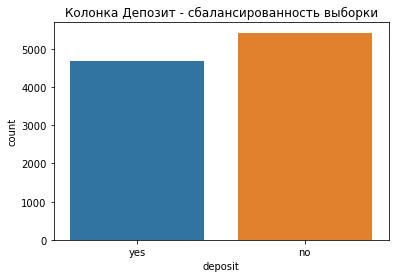

In [10]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(df_nb['deposit'].value_counts())

# Визуализация
ax=sns.countplot(x='deposit', data=df_nb);
ax.set_title('Колонка Депозит - сбалансированность выборки')

Видим, что число открывших депозит составляет 46%. Соотношение классов можно признать относительно сбалансированным.

### Задания 2 и 3

In [11]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
display(df_nb.describe())
print('Максимальный возраст клиента банка (лет):', df_nb['age'].max())
print ('Минимальная продолжительность разговора с клиентом банка (в секундах):', df_nb['duration'].min())

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Максимальный возраст клиента банка (лет): 95
Минимальная продолжительность разговора с клиентом банка (в секундах): 2


Медианный (средний) возраст клиента составляет 38-40 лет. В этом возрасте люди уже нередко имеют вступающих во взрослую жизнь детей, которым нужна будет поддержка на первых порах, да и жизни в старости стоит подумать. Соответственно возникает потребность в создании сбережений на будущее.

Длительность разговора с клиентом составляет обычно 4-6 минут: вполне достаточный срок, чтобы оговорить основные детали.

Хотя в каждой из рассматриваемых категорий присутствуют аномальные показатели, вроде имеющихся показателей максимального возраста клиента банка и минимальной продолжительности разговора с клиентом

Text(0.5, 1.0, 'Возраст клиентов банка')

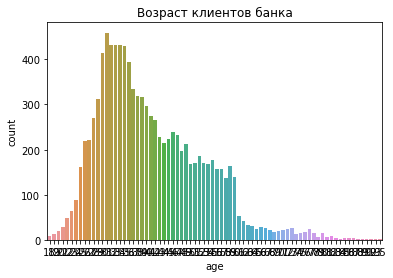

In [12]:
# Визуализация возраста
ax = sns.countplot(x='age', data=df_nb);
ax.set_title('Возраст клиентов банка')

Text(0.5, 1.0, 'Продолжительность разговоров с клиентом')

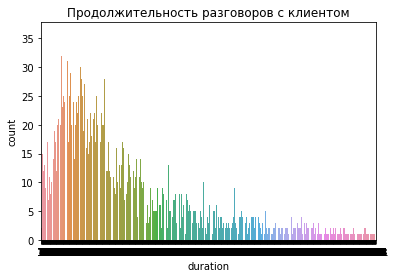

In [13]:
# Визуализация продолжительности разговоров с клиентом
ax = sns.countplot(x='duration', data=df_nb)
ax.set_title('Продолжительность разговоров с клиентом')

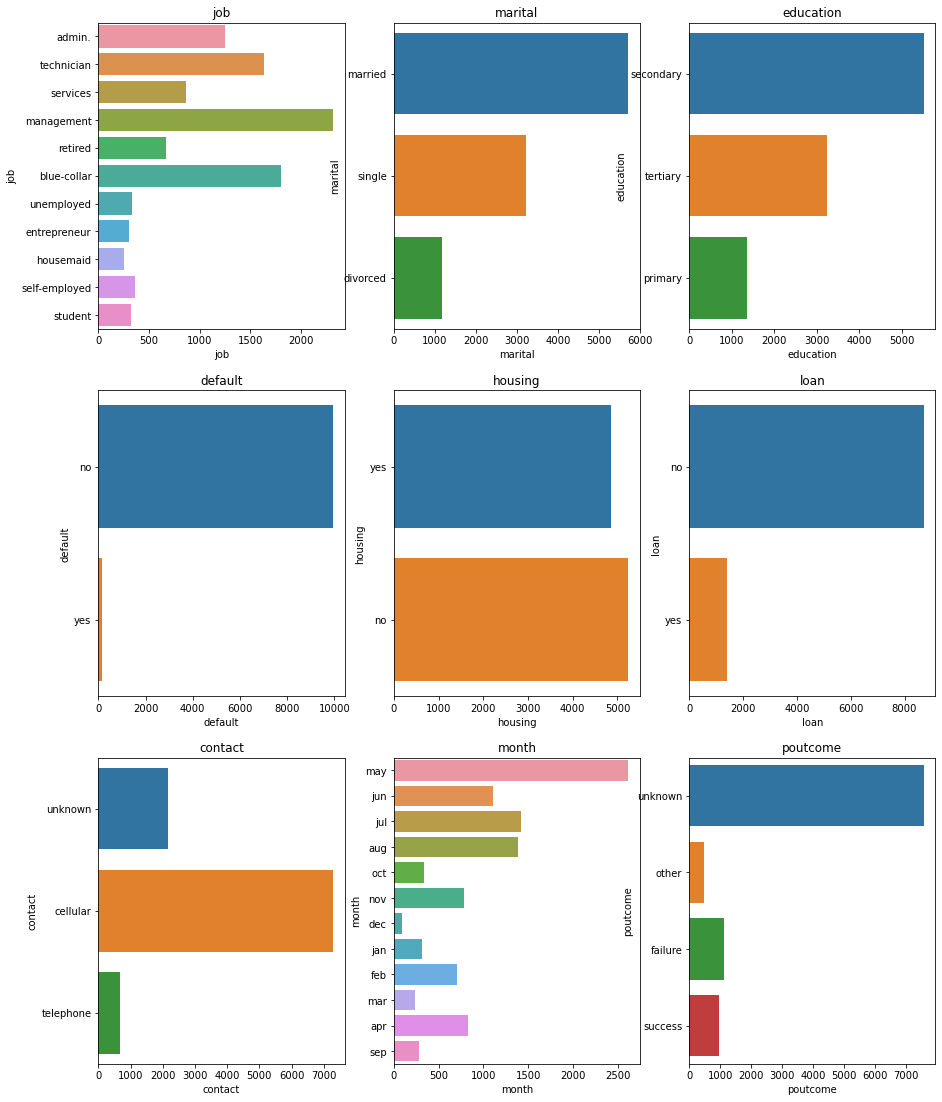

In [14]:
df_nb.describe(include = 'object')
categorical_features=[feature for feature in df_nb.columns if ((df_nb[feature].dtypes=='O') & (feature not in ['deposit']))]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df_nb)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


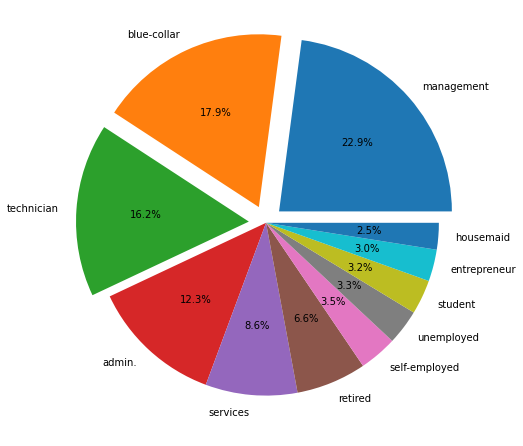

In [15]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
display(df_nb.describe(include = 'object'))
#постройте визуализации, иллюстрирующие результаты

x = df_nb['job'].value_counts()
jobs = df_nb['job'].value_counts()[:11]
fig = plt.figure(figsize=(6, 6))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    x,
    labels=x.index,
    autopct='%.1f%%',
    explode = [0.1, 0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0]
);

Среди сфер занятости лидируют (в порядке убывания) management, blue-collar, technician. Всего сфер занятости 11.

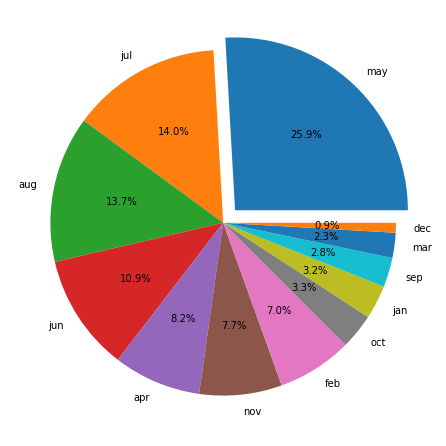

In [16]:
x = df_nb['month'].value_counts()
jobs = df_nb['month'].value_counts()[:11]
fig = plt.figure(figsize=(6, 6))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    x,
    labels=x.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);

Маркетинговые кампании проводятся ежемесячно, особенно активно - в мае и в летние месяцы

### Задание 6

<AxesSubplot:xlabel='poutcome'>

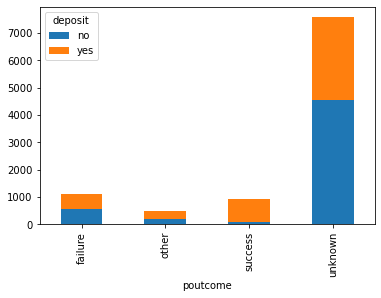

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = df_nb.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

Подтвердилось, что наиболее успешным статусом яаляется статус с "говорящим" названием success. Присутствует большое количество данных с неопределенным статусом unknown.

### Задание 7

In [18]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

# извлекаем статистику помесячно
bb= df_nb.groupby('deposit')['month'].value_counts()

# Создаем и заполняем словари статистикой по 'no' (словарь neg_reaction) и 'yes' (словарь pos_reaction)
neg_reaction = {}
pos_reaction = {}
for i in range(len(bb)):
    if i < 12:
        neg_reaction[bb.index[i][1]] = bb.iloc[i]
    else:
        pos_reaction[bb.index[i][1]] = bb.iloc[i]

# создаем список year  с названиями месяцев для сравнения (в задании 3 этого раздела показано, что рекламная компания была
# круглогодично, поэтому мы включаем в список месяцев ВСЕ месяцы)
year = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# создаем новый словарь year_df, в который заносим название месяца и долю отказов в этом месяце
year_df = {}
for k in range(len(year)):
    proc = neg_reaction[year[k]]/(neg_reaction[year[k]] + pos_reaction[year[k]])
    year_df[year[k]] = proc
# преобразуем словарь year_df в датафрейм    
df_month = pd.DataFrame([year_df])
display(df_month)

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,0.60815,0.455571,0.101266,0.381928,0.67864,0.548913,0.589563,0.559567,0.165468,0.185075,0.584615,0.096774


Из приведенной выше таблицы видно, что наибольшая доля отказов фиксируется в мае и равна примерно 0.68. 

Также большие доли отказов зафиксированы в летние месяцы. Это хорошо коррелирует с увеличением расходов на рекламу в мае и в летние месяцы, что было показано выше (задание 5).

Увеличивающаяся доля отказов в эти месяцы имеет свою  логику: люди привыкли в эти месяцы брать отпуска (тратить деньги) и меньше думают о вложениях.

### Задание 8

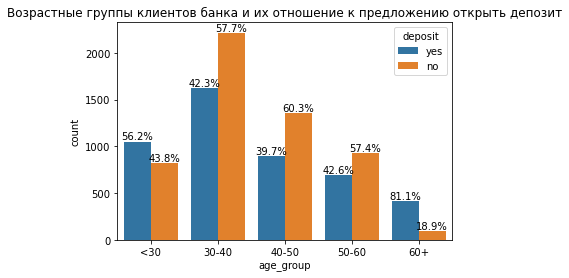

In [19]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

def barPerc(df,xVar,ax):
    # для вывода процентов на диаграмме использоваана модификация функции из 
    # https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-grouped-bars
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable 
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.1%}',
                    ha="center",va="bottom")

df_nb['age_group'] = pd.cut(df_nb.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

ax = sns.countplot(x='age_group', hue='deposit', data=df_nb)
ax.set_title('Возрастные группы клиентов банка и их отношение к предложению открыть депозит')
barPerc(df_nb, 'age_group', ax)

Видим, что более склонны открывать депозит, чем отказываться от предложения группы клиентов менее 30 лет и более 60 лет.

### Задания 9 и 10

Text(0.5, 1.0, 'Семейный статус и отношение к наличию депозита')

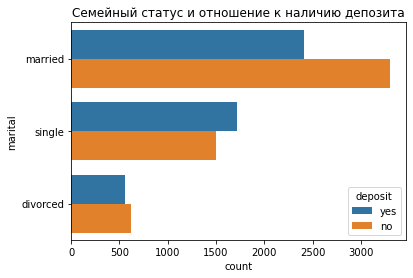

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
ax = sns.countplot(y='marital', hue='deposit', data=df_nb)
ax.set_title('Семейный статус и отношение к наличию депозита')

Text(0.5, 1.0, 'Образование клиента и отношение к наличию депозита')

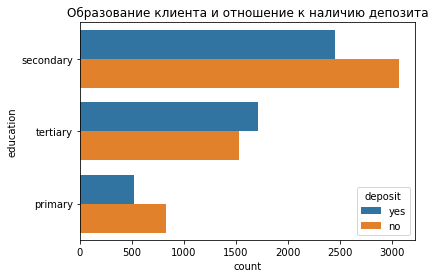

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ax = sns.countplot(y='education', hue='deposit', data=df_nb)
ax.set_title('Образование клиента и отношение к наличию депозита')

Text(0.5, 1.0, 'Профессия клиента и отношение к наличию депозита')

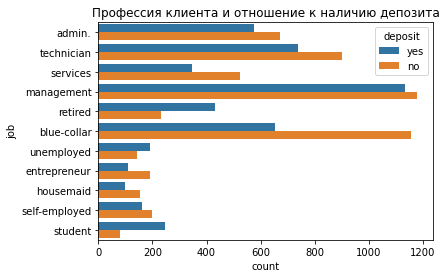

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
ax = sns.countplot(y='job', hue='deposit', data=df_nb)
ax.set_title('Профессия клиента и отношение к наличию депозита')

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


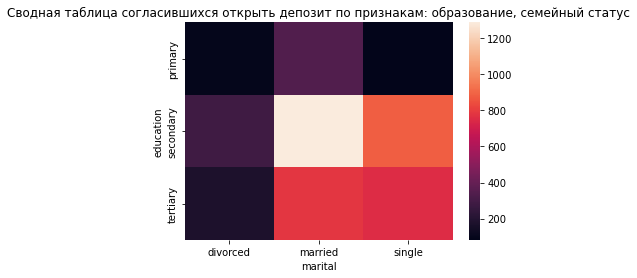

In [23]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pos_1 = df_nb[df_nb.deposit == 'yes'][['education','marital','deposit']]
pos_2 = df_nb[df_nb.deposit == 'no'][['education','marital','deposit']] 

cross_1 = pd.crosstab(pos_1['education'], pos_1['marital'])
cross_2 = pd.crosstab(pos_2['education'], pos_2['marital'])
display(cross_1)

ax = plt.axes()
sns.heatmap(cross_1, ax = ax)

ax.set_title('Сводная таблица согласившихся открыть депозит по признакам: образование, семейный статус')
plt.show()


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


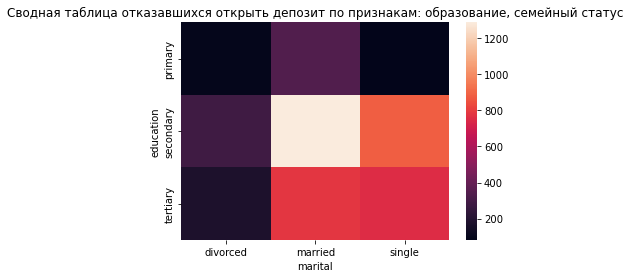

In [24]:
display(cross_2)

ax = plt.axes()
sns.heatmap(cross_1, ax = ax)

ax.set_title('Сводная таблица отказавшихся открыть депозит по признакам: образование, семейный статус')
plt.show()

Как получается в обоих случаях ( согласившихся и отказавшихся) наиболее многочисленной группой являются secondary и married (со средним образованием, женатые)

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_nb['education'] = lab_enc.fit_transform(df_nb['education'])

# Найдите сумму получившихся значений для признака education
df_nb['education'].sum()

11995

In [26]:
# Аналогичным образом преобразуем признаки age и  age_group
df_nb['age'] = lab_enc.fit_transform(df_nb['age'])
df_nb['age_group'] = lab_enc.fit_transform(df_nb['age_group']) 

In [27]:
df_nb.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,41,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,38,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,23,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1


In [28]:
df_nb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int32  
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
 17  age_group  10105 non-null  int32  
dtypes: float64(1), int32(2), int64(6), object(9)
memory usage: 1.4+ MB


In [29]:
df_nb['education'].value_counts()

1    5517
2    3239
0    1349
Name: education, dtype: int64

### Задания 2 и 3

In [30]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_nb['deposit'] = df_nb['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df_nb['default'] = df_nb['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_nb['housing'] = df_nb['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_nb['loan'] = df_nb['loan'].apply(lambda x: 1 if x == 'yes' else 0)
df_nb.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,41,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,38,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,23,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,37,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,36,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [31]:
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit.
print(round(df_nb['deposit'].std(), 3))

0.499


In [32]:
# Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа 
# впишите итог
itog = df_nb['default'].mean() + df_nb['housing'].mean() + df_nb['loan'].mean()
print(round(itog, 3))

0.635


### Задание 4

In [33]:
# создайте дамми-переменные
# df_nb.drop(['age_group'], inplace = True, axis = 1)
df_dm = pd.get_dummies(df_nb, columns=['job','marital', 'contact', 'month', 'poutcome'])
df_dm.shape

(10105, 46)

### Задания 5 и 6

In [34]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности


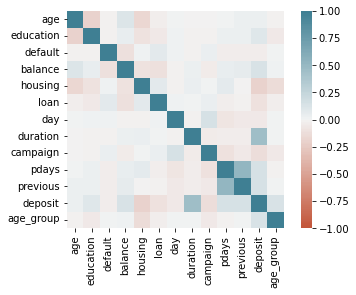

In [35]:
corr = df_nb.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

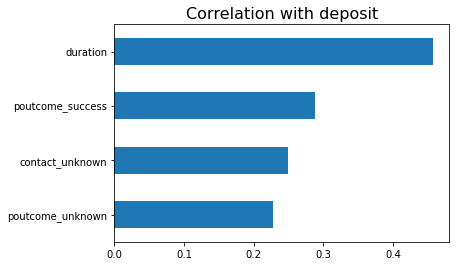

In [36]:
# В качестве дополнения визуализации к этому заданию постройте столбчатую диаграмму 
# для ранжированных коэффициентов корреляции.
corr = df_dm.corr()
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

In [37]:
corr = df_dm.corr()
new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


### Задания 7 и 8

In [39]:
# Определяем целевую переменную и предикторы, а также разделяем выборку на обучающую и тестовую.
X = df_dm.drop(['deposit'], axis=1)
y = df_dm['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [40]:
# рассчитайте необходимые показатели
# Каким получился размер тестовой выборки?
X_test.shape

(3335, 45)

In [41]:
# Каково среднее значение целевой переменной на тестовой выборке?
print(round(y_test.mean(), 2))

0.46


### Задание 9

In [42]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [43]:
# Делаем на основе 15 наиболее подходящих признаков переопределение обучающей и тестовой выборок
X = df_dm[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [44]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # transform() на train данных
X_test_scaled = scaler.transform(X_test)      # transform() на test данных
# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. 
print(X_test_scaled[:, 0].mean())

0.46823674223097866


In [45]:
X_test

,balance,housing,duration,campaign,pdays,previous,age_group,contact_cellular,contact_unknown,month_mar,month_may,month_oct,month_sep,poutcome_success,poutcome_unknown
3333,155.0,0,290,1,93,2,3,0,0,1,0,0,0,1,0
6048,512.0,0,70,1,-1,0,2,1,0,0,0,0,0,0,1
5675,1403.0,0,214,8,326,2,0,1,0,0,1,0,0,0,0
2564,1270.0,0,232,3,-1,0,0,1,0,0,0,0,0,0,1
8983,1074.0,1,523,2,-1,0,2,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,507.0,0,380,1,-1,0,4,1,0,0,0,0,0,0,1
9672,443.0,0,10,1,2,1,0,1,0,0,0,0,0,0,0
8584,-311.0,1,55,2,345,2,0,1,0,0,1,0,0,0,0
10972,250.0,0,133,1,-1,0,4,1,0,0,0,0,0,0,1


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [46]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Для получившейся модели вычислите значение accuracy на тестовой выборке. 
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))

accuracy на тестовом наборе: 0.81


### Задания 2,3,4

In [47]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
y_test_pred = dt.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy на обучающем наборе: 1.00
accuracy на тестовом наборе: 0.75


Наблюдаем переобучение модели: на обучающем наборе показывает идеальные результаты, но на на теством наборе качество обучения резко падает

In [48]:
# обучите решающие деревья, настройте максимальную глубину (глубина = 6)

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
y_test_pred = dt.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy на обучающем наборе: 0.82
accuracy на тестовом наборе: 0.81


In [49]:
# обучите решающие деревья, настройте максимальную глубину (глубина = 12)

dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 12
)

dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
print("accuracy на обучающем наборе: {:.2f}".format(dt.score(X_train_scaled, y_train)))
y_test_pred = dt.predict(X_test_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(dt.score(X_test_scaled, y_test)))

accuracy на обучающем наборе: 0.89
accuracy на тестовом наборе: 0.79


Вновь наблюдаем переобучение модели при max_depth = 12

**Вывод:** максимальное значение метрики accuracy, но при этом ещё не наблюдается переобучение, достигнуто при глубине max_depth = 6 (проверено и на других значениях от 1 до 12 включительно)

### Задание 5

Реализуйте оптимизацию гиперпараметров с помощью GridSearch, перебрав следующие параметры:

* 'min_samples_split': [2, 5, 7, 10];
* 'max_depth':[3,5,7].

Оцените метрику F1 на тестовой выборке для наилучшей комбинации перебираемых параметров. 

In [50]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)
print("Наилучшие значения параметров: {}".format(model_cv.best_params_))
y_test_pred = model_cv.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 2}
f1_score на тестовом наборе: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [51]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
print('accuracy на тестовом наборе: {:.2f}'.format(rf.score(X_test_scaled, y_test)))
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
recall на тестовом наборе: 0.83


Случайный лес показывает более лучшие результаты, чем GridSearch

### Задания 2 и 3

In [52]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

f1_score на тестовом наборе: 0.82
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [53]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=300,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



В целом градиентный бустинг показывает лучшие результаты, нежели случайный лес

### Задание 4

In [54]:
# объедините уже известные вам алгоритмы с помощью стекинга
#  оцените метрику precision на тестовой выборке
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)
y_train_pred = stack.predict(X_train_scaled)
y_test_pred = stack.predict(X_test_scaled)
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

precision на тестовом наборе: 0.81
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [55]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# оцените признаки 'duration', 'poutcome_success', 'contact_unknown' по убыванию важности

In [58]:
from sklearn.feature_selection import RFE

estimator = gb  # ранее использованный алгоритм градиентного бустинга
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train_scaled, y_train)

print(X_train.columns) # выводим список из 15 признаков, которые отобраны для обучения модели
print(selector.get_feature_names_out()) # наиболее важные признаки
print(selector.ranking_) # рейтинг наиболее важных признаков

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')
['x2']
[ 3  6  1 10  5 13  7 14  4  8 11  9 12  2 15]


Наиболее важные признаки по методу RFE: 'duration', 'poutcome_success', 'balance', их места в рейтинге отражены в последнем выводимом списке.

Эти признаки в наибольшей степени отражают готовность клиента открыть депозит. 
* Признак  'balance' отражает наличие и сумму денег в банке (если денег нет, то и о депозите не будешь думать).
* Признак  'duration' показывает длительность переговоров с клиентом (если клиент не заинтересован, то и продолжать разговор он не будет).
* Наконец, признак  'poutcome_success' демонстрирует успешность прошлой рекламной кампании (имея положительный опыт, его клиент часто повторяет).

Соответственно, если выбирать по важности из признаков 'duration', 'poutcome_success', 'contact_unknown', то их места в рейтинге получаются следующими: 1, 2 и 15.

### Задания 6,7,8

In [130]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
random_state = 42
import optuna
print("Версия Optuna: {}".format(optuna.__version__))

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

Версия Optuna: 3.0.2


In [131]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-06 13:26:18,368] A new study created in memory with name: RandomForestClassifier
[I 2022-10-06 13:26:18,980] Trial 0 finished with value: 0.8502340093603745 and parameters: {'n_estimators': 122, 'max_depth': 19, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8502340093603745.
[I 2022-10-06 13:26:19,881] Trial 1 finished with value: 0.8681661980631054 and parameters: {'n_estimators': 166, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8681661980631054.
[I 2022-10-06 13:26:20,811] Trial 2 finished with value: 0.8574097135740971 and parameters: {'n_estimators': 182, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8681661980631054.
[I 2022-10-06 13:26:21,683] Trial 3 finished with value: 0.8755673814368445 and parameters: {'n_estimators': 158, 'max_depth': 17, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8755673814368445.
[I 2022-10-06 13:26:22,644] Trial 4 finished with value: 0.8506107109301597 and parameters: {'n_

CPU times: total: 15.9 s
Wall time: 15.8 s


In [135]:
# выводим наилучшие значения гиперпараметров
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
# print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 141, 'max_depth': 27, 'min_samples_leaf': 2}


In [136]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


In [137]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Результат по методу Optuna не хуже, чем другими методами